### Problem Description

#### **Sales forecasting of a pharmaceutical retail chain**

KioMed, a huge pharmaceutical retailer, operates in in 10+ cities across India. The company has one distribution warehouse in each of the cities it operates in. Unfortunately, the warehouses are not able to consistently meet the demand of the stores in their respective cities. Kio, the parent company, being a data driven corporation wants to solve the stocking / inventory management problem using their in-house data science team.

The retailer has provided you with historical sales data and is looking to forecast the sales for the period of one month aPer the end of the data. These forecasts will be used to ensure that the company is able to stock its supplies of medicines in a warehouse accordingly in each city for a period of one month.

#### City records ▶
1 : Kolkata, 2 : Other,   3 : Jaipur,  4: Mumbai,   5 : Delhi, 6: Chennai, 7 : Bangalore, 8: Hyderabad, 9 : Ahmedabad, 10 : Lucknow 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir(r'/content/gdrive/MyDrive/Final_project/')

In [3]:
!pip install category_encoders
# !pip install dask 

     |████████████████████████████████| 82 kB 343 kB/s 


In [4]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gc
from PIL import Image
from pylab import rcParams
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

import pickle
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def data_optimize(df, object_option=False):
    """Reduce the size of the input dataframe
    Parameters
    ----------
    df: pd.DataFrame
        input DataFrame
    object_option : bool, default=False
        if true, try to convert object to category
    Returns
    -------
    df: pd.DataFrame
        data type optimized output dataframe
    """

    # loop columns in the dataframe to downcast the dtype
    for col in df.columns:
        # process the int columns
        if df[col].dtype == 'int':
            col_min = df[col].min()
            col_max = df[col].max()
            # if all are non-negative, change to uint
            if col_min >= 0:
                if col_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif col_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif col_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col]
            else:
                # if it has negative values, downcast based on the min and max
                if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                    df[col] = df[col].astype(np.int8)
                elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                    df[col] = df[col].astype(np.int16)
                elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col]
                    
        # process the float columns
        elif df[col].dtype == 'float':
            col_min = df[col].min()
            col_max = df[col].max()
            # downcast based on the min and max
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col]

        if object_option:
            if df[col].dtype == 'object':
                if len(df[col].value_counts()) < 0.5 * df.shape[0]:
                    df[col] = df[col].astype('category')

    return df

In [6]:
# Function to understand the Datatypes , NA values, Unique values and there counts

def understand_data(data) :
  print('Data size :',data.shape)
  return(pd.DataFrame({"Datatype":data.dtypes,"No of NAs":data.isna().sum(),
                       "Unique_count":data.apply(lambda x: x.nunique(),axis=0),
                       "Unique_values":data.apply(lambda x: str(x.unique()),axis=0)}))

# Calculate memory usage

def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

### Import data

In [ ]:
%%time
# Read the data file
train_data = pd.read_csv('train_data.csv', parse_dates= {"date" : ["year","month","day"]}, keep_date_col=True)   
test_data = pd.read_csv('test_data.csv', parse_dates= {"date" : ["year","month","day"]}, keep_date_col=True)
foot_fall = pd.read_csv('foot_fall.csv')
discounted = pd.read_csv('discount_features.csv', parse_dates=['date']) 

CPU times: user 19.2 s, sys: 2.83 s, total: 22.1 s
Wall time: 27.7 s


#### Train data

In [ ]:
# check tge memory usage and change the data type accordingly
print('Memory Usage to load train_data : ', mem_usage(train_data))
print(train_data.head(2))
train_data[['year','month','day']] = train_data[['year','month','day']].astype('int64')

train_data = data_optimize(train_data) # optimize data
print('Memory Usage after optimization : ', mem_usage(train_data))  # print memory comsumed
understand_data(train_data)  # understand the data set

Memory Usage to load train_data :  4529.62 MB
        date  year month day  city  medicine  sales
0 2015-01-02  2015     1   2     1         1   24.0
1 2015-01-02  2015     1   2     1         2  144.0
Memory Usage after optimization :  409.95 MB
Data size : (22624345, 7)


,Datatype,No of NAs,Unique_count,Unique_values
date,datetime64[ns],0,1269,['2015-01-02T00:00:00.000000000' '2015-01-03T0...
year,uint16,0,4,[2015 2016 2017 2018]
month,uint8,0,12,[ 1 2 3 4 5 6 7 8 9 10 11 12]
day,uint8,0,31,[ 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
city,uint8,0,10,[ 1 2 3 4 5 6 7 8 9 10]
medicine,uint16,0,3389,[ 1 2 3 ... 3387 3388 3389]
sales,float32,0,175574,[ 24. 144. 84. ... 495.848 1194....


#### Test data

In [ ]:
# Test_data

print('Memory Usage to load train_data : ', mem_usage(test_data))
test_data[['year','month','day']] = test_data[['year','month','day']].astype('int64')

test_data = data_optimize(test_data)   # optimize memory
print('Memory Usage after optimization : ', mem_usage(test_data))
understand_data(test_data)

Memory Usage to load train_data :  154.70 MB
Memory Usage after optimization :  14.02 MB
Data size : (773535, 7)


,Datatype,No of NAs,Unique_count,Unique_values
date,datetime64[ns],0,31,['2018-07-01T00:00:00.000000000' '2018-07-02T0...
id,uint32,0,773535,[ 1 2 3 ... 773533 773534 773535]
year,uint16,0,1,[2018]
month,uint8,0,1,[7]
day,uint8,0,31,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
city,uint8,0,10,[ 1 2 3 4 5 6 7 8 9 10]
medicine,uint16,0,3289,[1292 1 2 ... 3422 3423 358]


There is almost **10X** decrease in the size of data after type conversion.

#### Footfall data

In [ ]:
%%time
# Lets convert columns to rows and get them in required order

foot_fall = data_optimize(foot_fall)   # optimize data

alvarlist = [col for col in foot_fall if 
                      ('2' in col) or ('0' in col) or ('-' in col)]

foot_seq =pd.melt(foot_fall, id_vars="city", 
                   value_vars = alvarlist,
                    var_name="Date", value_name="value")
print('Memory Usage to load foot_seq : ', mem_usage(foot_seq))
print(foot_seq.head())
foot_seq = data_optimize(foot_seq)   # optimize data


understand_data(foot_seq)

Memory Usage to load foot_seq :  1.63 MB
        city        Date    value
0  Ahmedabad  2015-01-02   9384.0
1  Bangalore  2015-01-02  16644.0
2    Chennai  2015-01-02  19544.0
3      Delhi  2015-01-02  16832.0
4  Hyderabad  2015-01-02  13588.0
Data size : (12670, 3)
CPU times: user 577 ms, sys: 9.01 ms, total: 586 ms
Wall time: 583 ms


#### Discounted data

In [ ]:
%%time
print(discounted.head(2))
print('\nMemory Usage:',mem_usage(discounted))
discounted = data_optimize(discounted)   # optimize memory
print('\nMemory Usage after optimization:',mem_usage(discounted))

        date  city  medicine  discounted
0 2016-04-01     1         1           0
1 2016-04-01     1         2           0

Memory Usage: 527.28 MB

Memory Usage after optimization: 197.73 MB
CPU times: user 290 ms, sys: 11 ms, total: 301 ms
Wall time: 300 ms


#### Merge train and discounted data

In [ ]:
# lets merge the data for better analysis 'train_data' + 'discounted'
merged_data = pd.merge(train_data, discounted, on= ['date','city','medicine'] , how = 'left')
print(merged_data.head(2))
print('Merged_data shape :',merged_data.shape)

print('\nMemory Usage : ',mem_usage(merged_data))
# As there is no discount offered in 2015 we will fill NA values with `0`



        date  year  month  day  city  medicine  sales  discounted
0 2015-01-02  2015      1    2     1         1   24.0         NaN
1 2015-01-02  2015      1    2     1         2  144.0         NaN
Merged_data shape : (22669553, 8)

Memory Usage :  756.68 MB


In [ ]:
merged_data.fillna(0, inplace = True)   # fill missing values in discounted column for 2015 with ` 0 `
merged_data['discounted'] = merged_data['discounted'].astype('int8')  # Decrease memory usage
print(merged_data['discounted'].value_counts())
merged_data = data_optimize(merged_data)  # optimize memory
print('\nMemory Usage :\n',mem_usage(merged_data))

0    21927459
1      742094
Name: discounted, dtype: int64

Memory Usage :
 605.34 MB


In [ ]:
# check the dtypes to see the memory reduced
merged_data.dtypes

date          datetime64[ns]
year                  uint16
month                  uint8
day                    uint8
city                   uint8
medicine              uint16
sales                float32
discounted              int8
dtype: object

In [ ]:
# Create a copy of the data to see if any time series patterns formed
mg = merged_data.copy()
mg['yearmonth'] = mg.date.dt.to_period('M')
mg.head()

# groupby with yearmonth with sales to see if there is any trend, or seasonal factor 
year_month_sales = mg.groupby(['yearmonth'])['sales'].mean().reset_index()

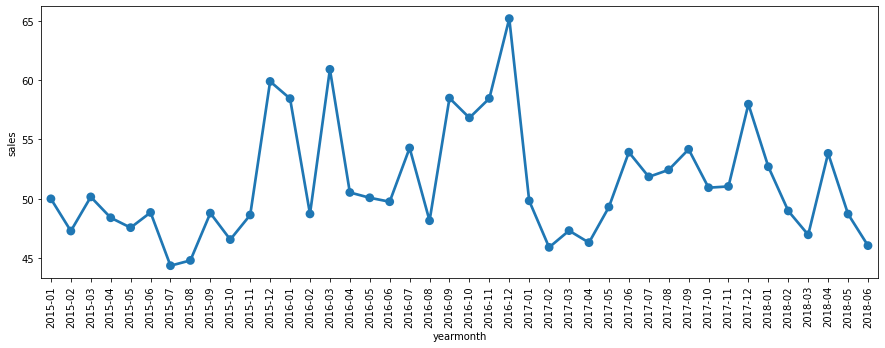

In [ ]:
# Plot the
plt.figure(figsize=(15,5))
sns.pointplot(x = year_month_sales.yearmonth, y = year_month_sales.sales)
plt.xticks(rotation = 90);

In [ ]:
year_month_sales.set_index('yearmonth', inplace = True)
year_month_sales.head()

,sales
yearmonth,
2015-01,49.990879
2015-02,47.276245
2015-03,50.152760
2015-04,48.395435
2015-05,47.558693


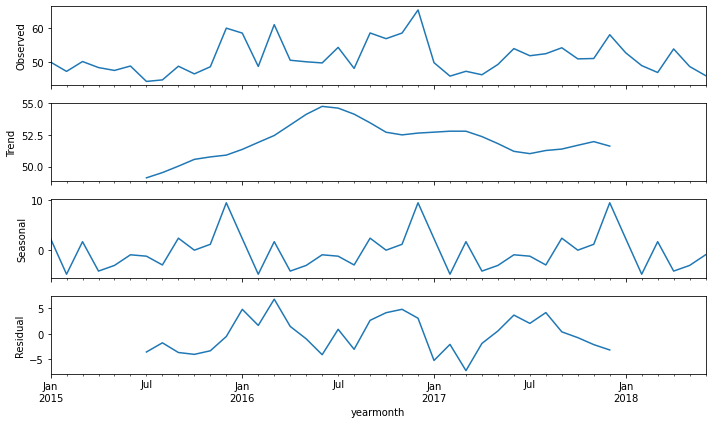

In [ ]:
# lets plot the decomptosition plot to check the trend, seasonality and random noise

from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 10,6
decomposition = sm.tsa.seasonal_decompose(year_month_sales, model = 'additive', freq = 12)
fig = decomposition.plot()
plt.show()

* There is no specific patter that can be seen in `Observed`.
* There is a increase in the initial period of trend line, but a slight decrese after July 2016.
* There is a Seasonality factor that can be seen here and we can say that the sales are higher at the end of the year.
* No pattern can be seen in the random/residual

#### Group data Analysis

In [ ]:
%%time
# Lets merge train data and foot fall data but first we need to group by train data

cities =  {1: "Kolkata", 2: "Other", 3: "Jaipur", 4: "Mumbai", 5: "Delhi",
           6: "Chennai", 7 : "Bangalore", 8 : "Hyderabad", 9 : "Ahmedabad", 10 : "Lucknow" }

train_data['city'] = [cities[item] for item in train_data['city']]

CPU times: user 4.09 s, sys: 22.9 ms, total: 4.12 s
Wall time: 4.08 s


In [ ]:
# Lets create a column for week

train_data['day_of_week'] = train_data['date'].dt.dayofweek
train_data['day_of_week'] = train_data['day_of_week'].astype('int8')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22624345 entries, 0 to 22624344
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   year         uint16        
 2   month        uint8         
 3   day          uint8         
 4   city         object        
 5   medicine     uint16        
 6   sales        float32       
 7   day_of_week  int8          
dtypes: datetime64[ns](1), float32(1), int8(1), object(1), uint16(2), uint8(2)
memory usage: 582.6+ MB


In [ ]:
%%time
# Group by the train_data w.r.t date
grouped_date = train_data.groupby(['date', 'city'], as_index=False)

grouped_data = grouped_date.agg({'medicine': np.size, 
                                 'sales': np.sum,
                                 'year':np.mean, 
                                 'month' : np.mean, 
                                 'day': np.mean, 
                                 'day_of_week': np.mean})
grouped_data.head()

CPU times: user 2.99 s, sys: 57.4 ms, total: 3.05 s
Wall time: 3.05 s


**Note** :Here medicine column is just the count of different medicine sold on that specific date.


**These are the dates that are missing from training records**

'2015-12-25' --> Christmas 2015

'2016-01-01' --> New year 2016

'2016-02-29' --> There is no such day in 2015 feb calender.

'2016-12-25' --> Christmas 2016

'2017-01-01' --> New year 2017

'2017-12-25' --> Christmas 2017

'2018-01-01' --> New year 2018

As all these are holidays we can ignore these days for now.

In [ ]:
# Convert Date to datetime
foot_seq['Date']= pd.to_datetime(foot_seq['Date'])

In [ ]:
# merge the 'FOOT_FALL' and 'TRAIN_DATA' dataset

grp_data = pd.merge(grouped_data, foot_seq, how = 'left',
                       left_on =['date', 'city'], 
                       right_on = ['Date', 'city'])  

grp_data.rename(columns = {'value': 'foot_fall'}, inplace = True)  # rename column
# As there are two date columns lets drop one of them
grp_data.drop('Date', axis = 1, inplace = True)

In [ ]:
grp_data.head()

,date,city,medicine,sales,year,month,day,day_of_week,foot_fall
0,2015-01-02,Ahmedabad,1161,65127.378906,2015,1,2,4,9384.0
1,2015-01-02,Bangalore,1209,109052.445312,2015,1,2,4,16644.0
2,2015-01-02,Chennai,1179,108599.679688,2015,1,2,4,19544.0
3,2015-01-02,Delhi,1233,110448.203125,2015,1,2,4,16832.0
4,2015-01-02,Hyderabad,1122,78800.000000,2015,1,2,4,13588.0


In [ ]:
# To get the sales pattern per day for the given data
grp_date = grp_data.groupby('date', as_index = False)
grp_date = grp_date.agg({'sales': np.sum,
                         'year':np.mean, 
                         'month' : np.mean, 
                         'day': np.mean, 
                         'day_of_week': np.mean,
                         'foot_fall': np.sum})

grp_date.head()

,date,sales,year,month,day,day_of_week,foot_fall
0,2015-01-02,8.676736e+05,2015,1,2,4,143104.0
1,2015-01-03,5.860972e+05,2015,1,3,5,114604.0
2,2015-01-04,6.155274e+05,2015,1,4,6,122364.0
3,2015-01-05,8.657492e+05,2015,1,5,0,151572.0
4,2015-01-06,1.008641e+06,2015,1,6,1,156052.0


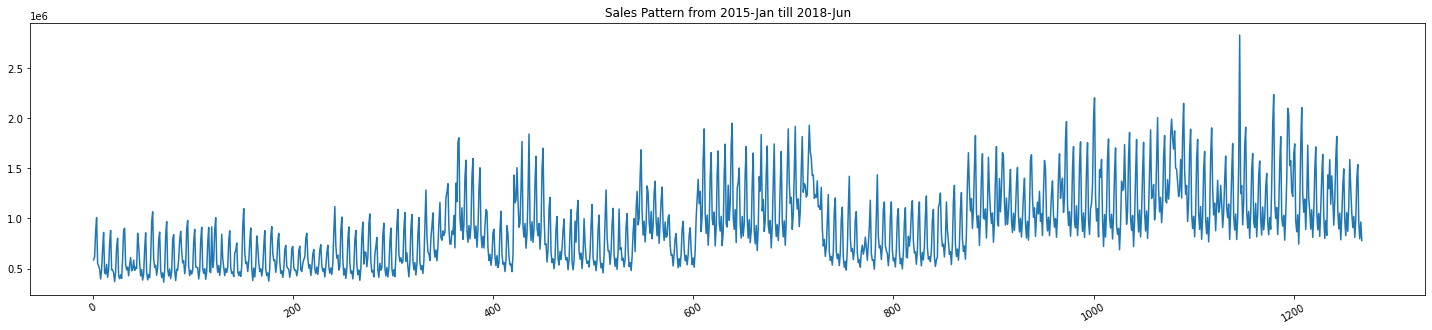

In [ ]:
from pylab import rcParams
rcParams["figure.figsize"] = 25,5
plt.plot(grp_date[1:1269]["sales"])
plt.title('Sales Pattern from 2015-Jan till 2018-Jun')
plt.xticks(rotation=30)
plt.show()

* THere is a increasing sales trend that can be seen from the above plot.

In [ ]:
# Lets check missing rowsfrom data

na_rows = grp_data[grp_data.isna().any(axis = 1)]
print(na_rows.shape)

(23, 9)


#### we have some missing data in foot_fall data for the`2018-01-02`, `2018-01-03` and `2018-01-04` 

In [ ]:
# Save the data file for future analysis

grp_data.to_csv('grp_data.csv')

In [ ]:
grp_data.head()

,date,city,medicine,sales,year,month,day,day_of_week,foot_fall
0,2015-01-02,Ahmedabad,1161,65127.378906,2015,1,2,4,9384.0
1,2015-01-02,Bangalore,1209,109052.445312,2015,1,2,4,16644.0
2,2015-01-02,Chennai,1179,108599.679688,2015,1,2,4,19544.0
3,2015-01-02,Delhi,1233,110448.203125,2015,1,2,4,16832.0
4,2015-01-02,Hyderabad,1122,78800.000000,2015,1,2,4,13588.0


# Exploratory Data Analysis

In [ ]:
# Call the grouped data for analysis
grp_data = pd.read_csv('grp_data.csv')
grp_data = grp_data.drop('Unnamed: 0', axis = 1)
grp_data = data_optimize(grp_data)

In [ ]:
grp_data.head()

,date,city,medicine,sales,year,month,day,day_of_week,foot_fall
0,2015-01-02,Ahmedabad,1161,65127.378906,2015,1,2,4,9384.0
1,2015-01-02,Bangalore,1209,109052.445312,2015,1,2,4,16644.0
2,2015-01-02,Chennai,1179,108599.679688,2015,1,2,4,19544.0
3,2015-01-02,Delhi,1233,110448.203125,2015,1,2,4,16832.0
4,2015-01-02,Hyderabad,1122,78800.000000,2015,1,2,4,13588.0


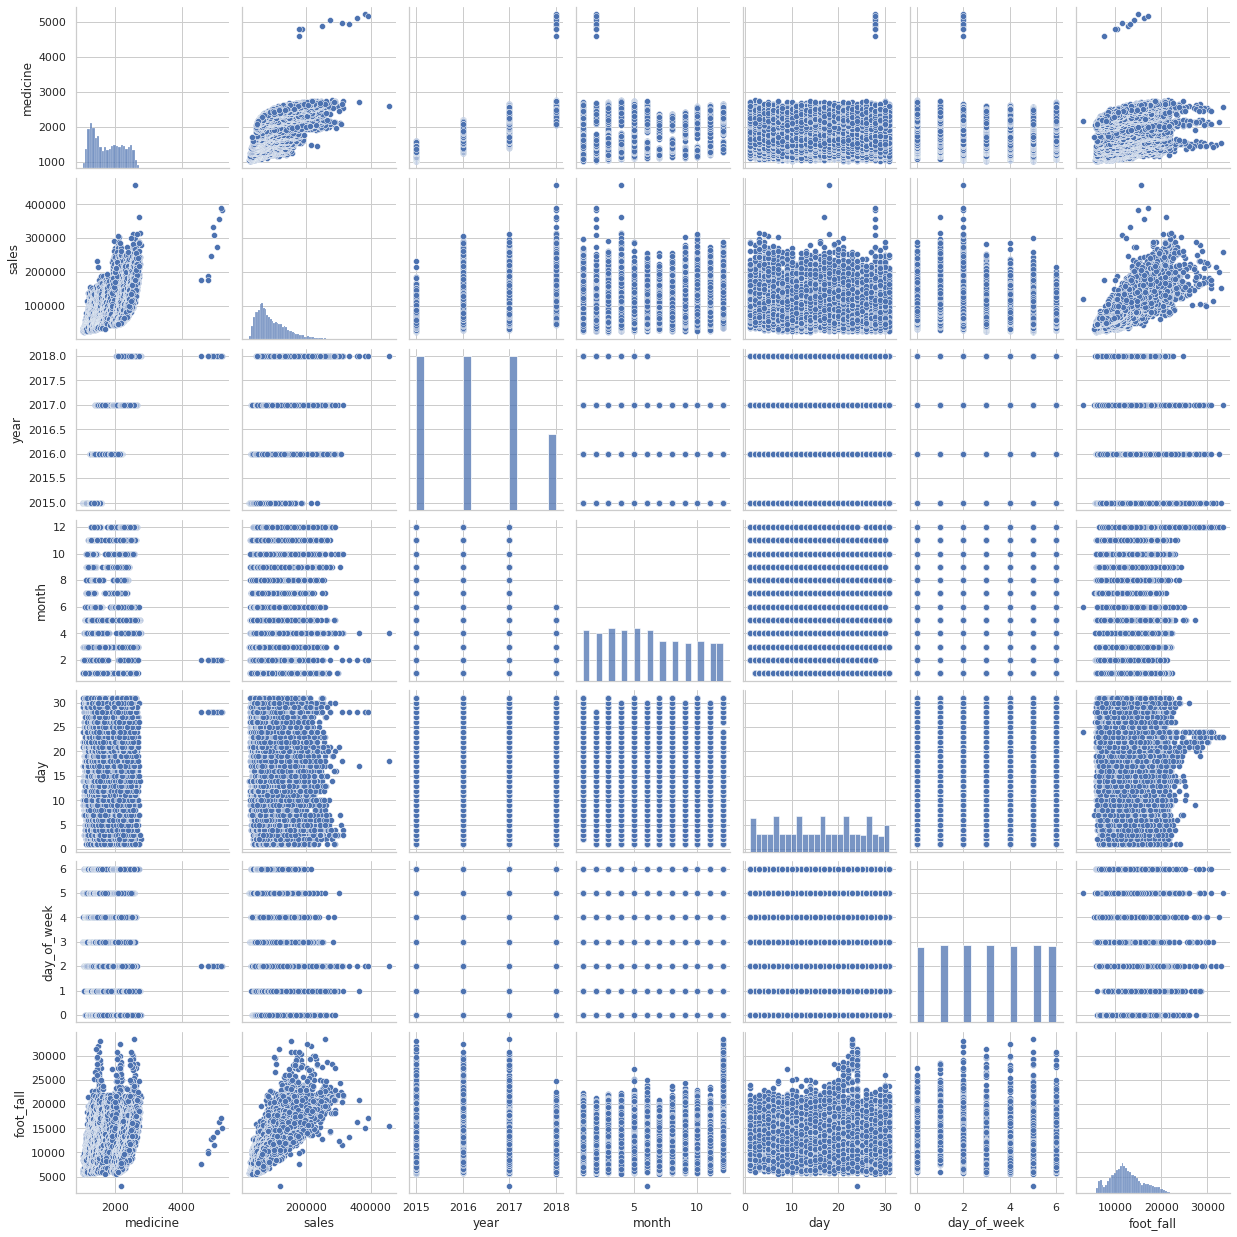

In [ ]:
# Over all idea of the data set

sns.pairplot(grp_data)

Text(0.5, 1.0, 'Foot_fall vs Sales')

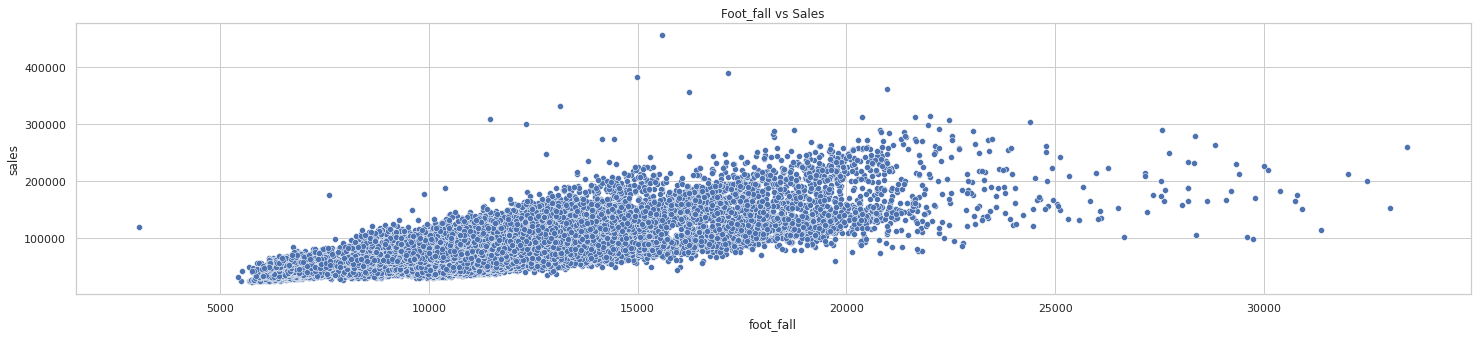

In [ ]:
sns.set(style="whitegrid")
sns.scatterplot(x='foot_fall', y ='sales', data=grp_data)
plt.title('Foot_fall vs Sales')

#### Observation:

* Sales and Foot_fall shows and increasing trend so we can say that as Foot_fall increases sales increases gradually.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


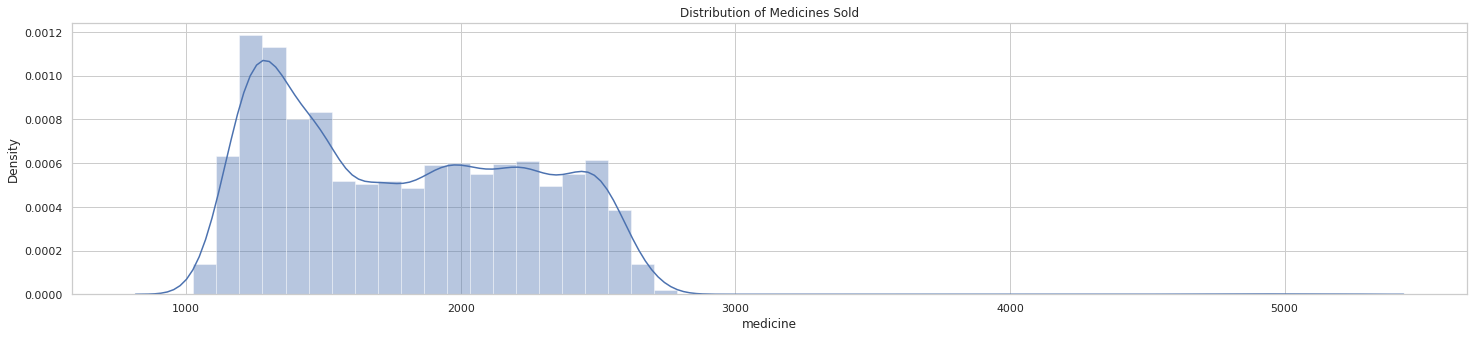

In [ ]:
sns.distplot(grp_data['medicine'], kde = True)
plt.title('Distribution of Medicines Sold');   # this plot only shows count of medicines sold per day and its distribution


In [ ]:
def countplot(x,df):
    bar_plot1 = sns.countplot(x=x, data=df, order = df[x].value_counts().index)
    for p in bar_plot1.patches:
        height = p.get_height()
        bar_plot1.text(p.get_x()+ p.get_width()/2, height + 1, height)

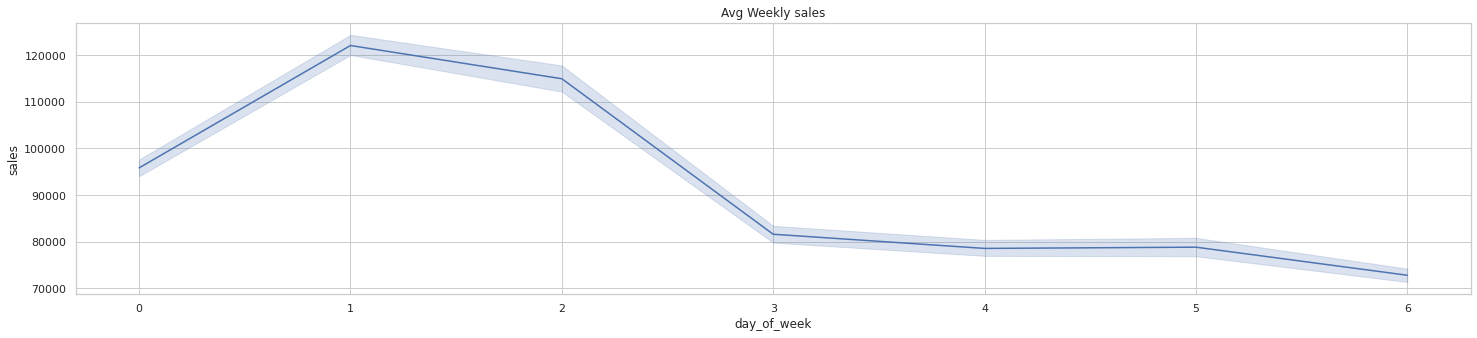

In [ ]:
sns.lineplot(x='day_of_week', y='sales', data=grp_data)
plt.title('Avg Weekly sales');

* Here day of the week with Monday=0, Sunday=6.
 
#### Assumptions/Insights to the Business: (From the given data)
1. Most of the sales could possibly be from the business man(Hospitals / medical shop owners / retailers/ distributors).
2. Working class people might be coming on weekends and they might have specific requirements.

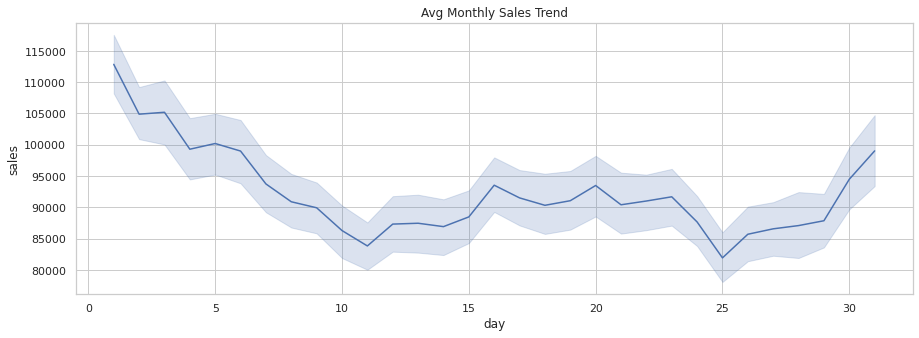

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='day', y='sales', data=grp_data)
plt.title('Avg Monthly Sales Trend');

### Observation:
* From the plot we see the highest sales on the first day of the month, from then it has a decreasing trend.
* Later at the end of month it has an increasing trend.

### Insight to Business:
* Most of the medicines to be made availible in the first week and the last week of the month.


### Yearly sales

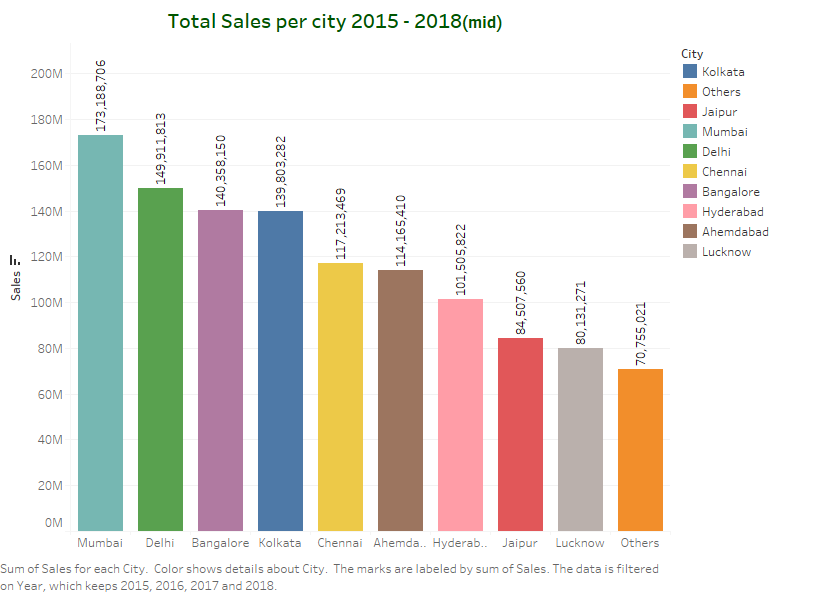

In [ ]:
# Read image
Total_sales = Image.open('tableau_graphs/Total sales per city.png')
  
# Output Images
Total_sales

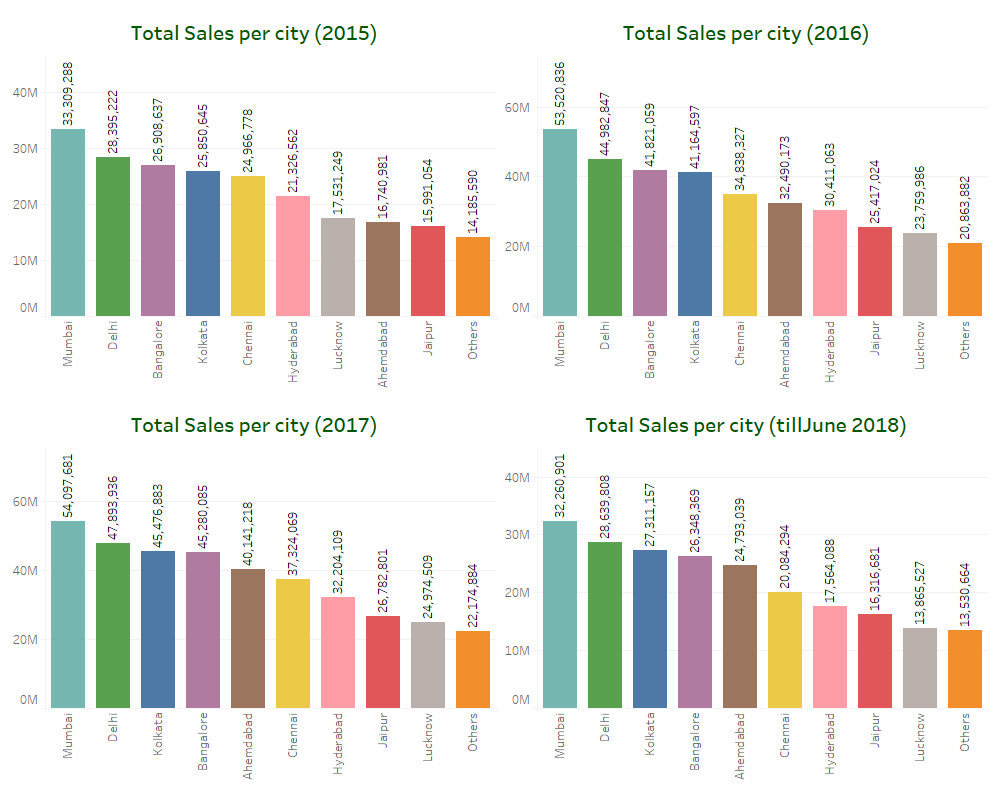

In [ ]:
# Read image
D_citywise_sales = Image.open('tableau_graphs/D_citywise_sales.png')
  
# Output Images
D_citywise_sales

### Observations

* As per data Mumbai, Delhi, Kolkata, Bangalore are the top 4 locations where the sales are the highest in the country
* Ahemdabad, Chennai and Hyderabad are the locations which are the areas of improvement.
* Jaipur, Lucknow and others being the lowest.

## Capture the Trend in Sales

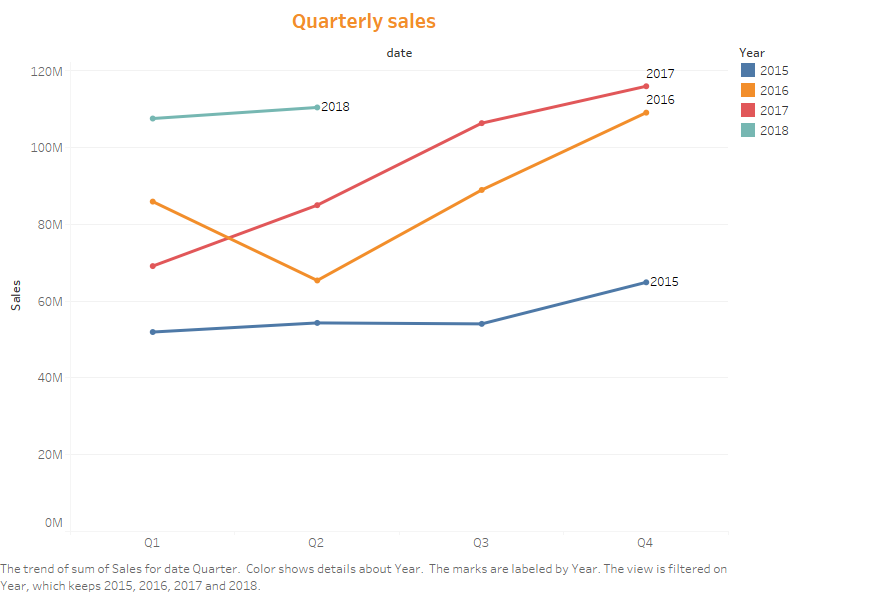

In [ ]:
# Read image
Quarterly_sales = Image.open('tableau_graphs/Quarterly sales.png')
  
# Output Images
Quarterly_sales

### Observations

* There is an increasing Trend that can been seen from the above graph.
* Sales increases in the last quarter

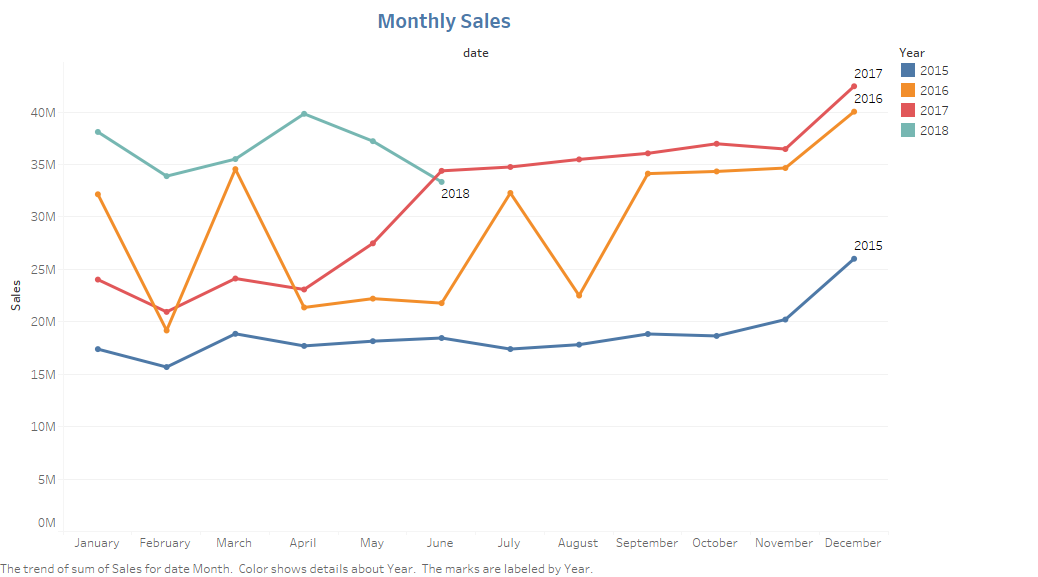

In [ ]:
# Read image
sales_trend = Image.open('tableau_graphs/Monthly sales.png')
  
# Output Images
sales_trend

* There is an increasing Trend that can been seen from the above graph.
* Sales goes high towards the end of the Year.

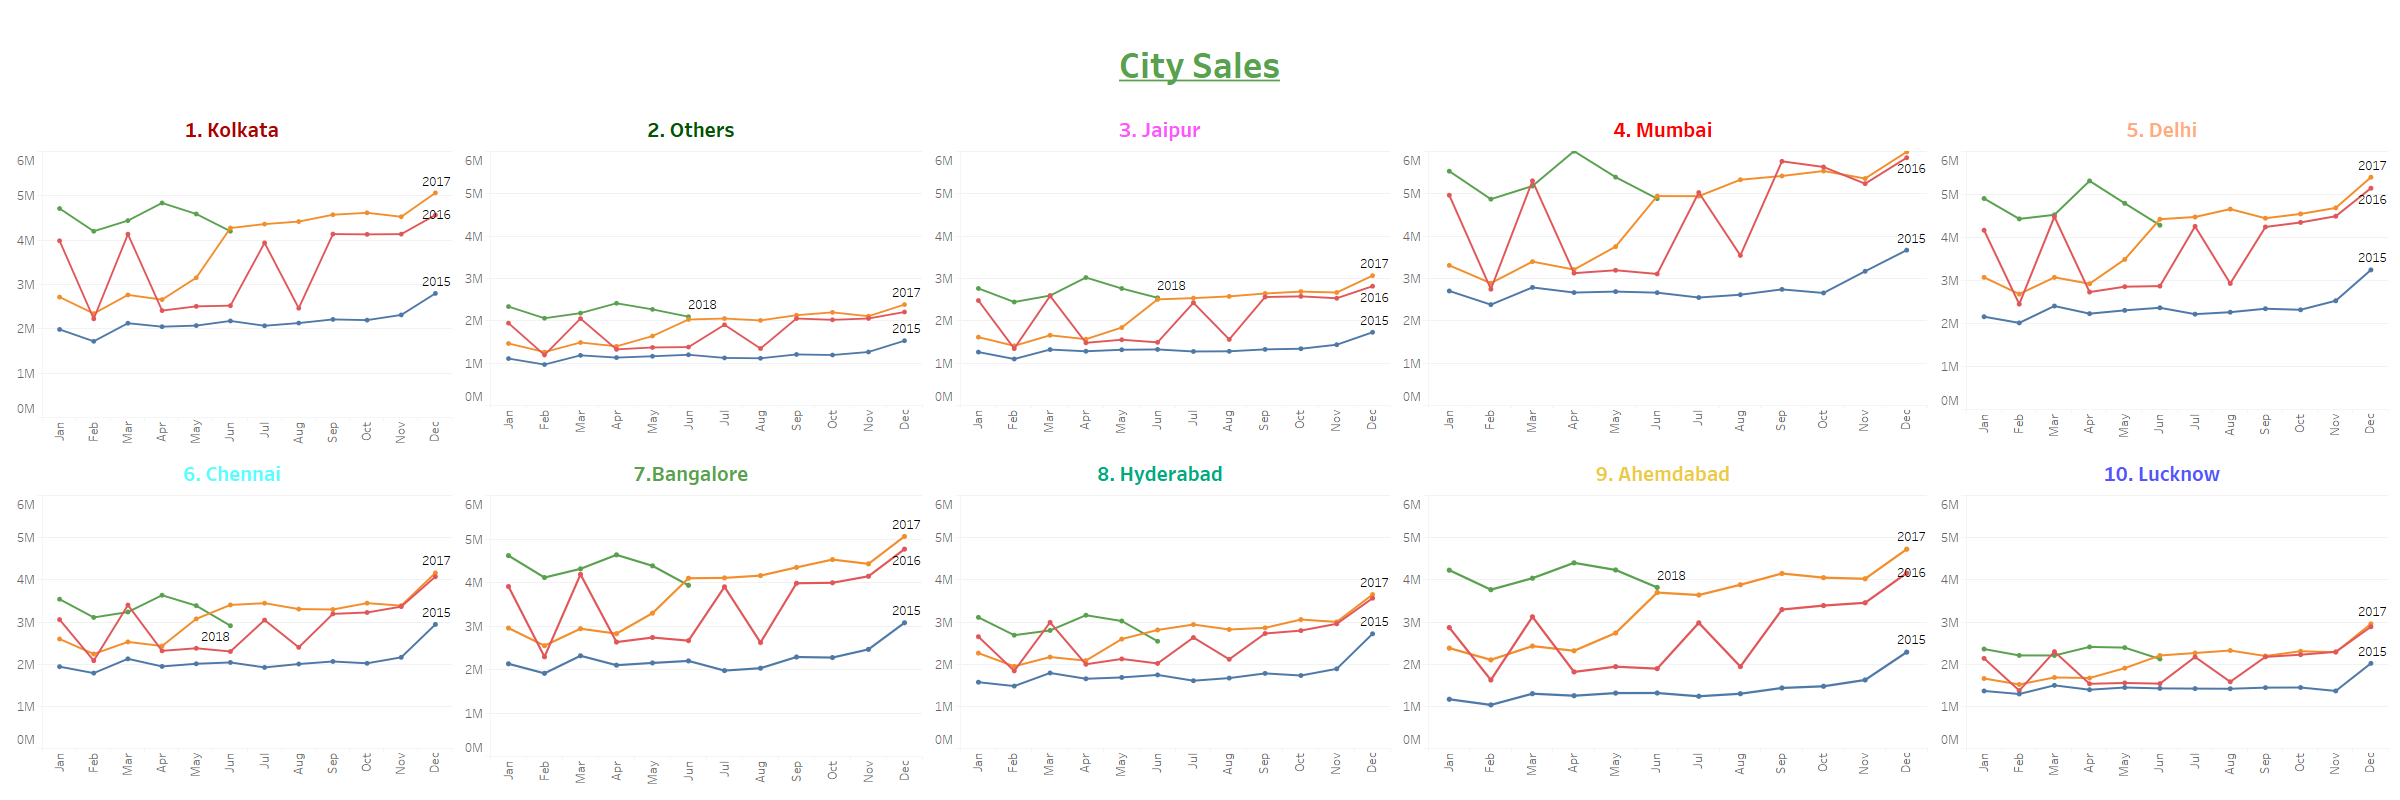

In [ ]:
# Read image
D_City_sales = Image.open('tableau_graphs/D_City_sales.png')
  
# Output Images
D_City_sales

* This graph shows over view of trend across cities.
* Mumbai, Delhi, Kolkata and Bangalore are the top 4 cities where we can see high sales.

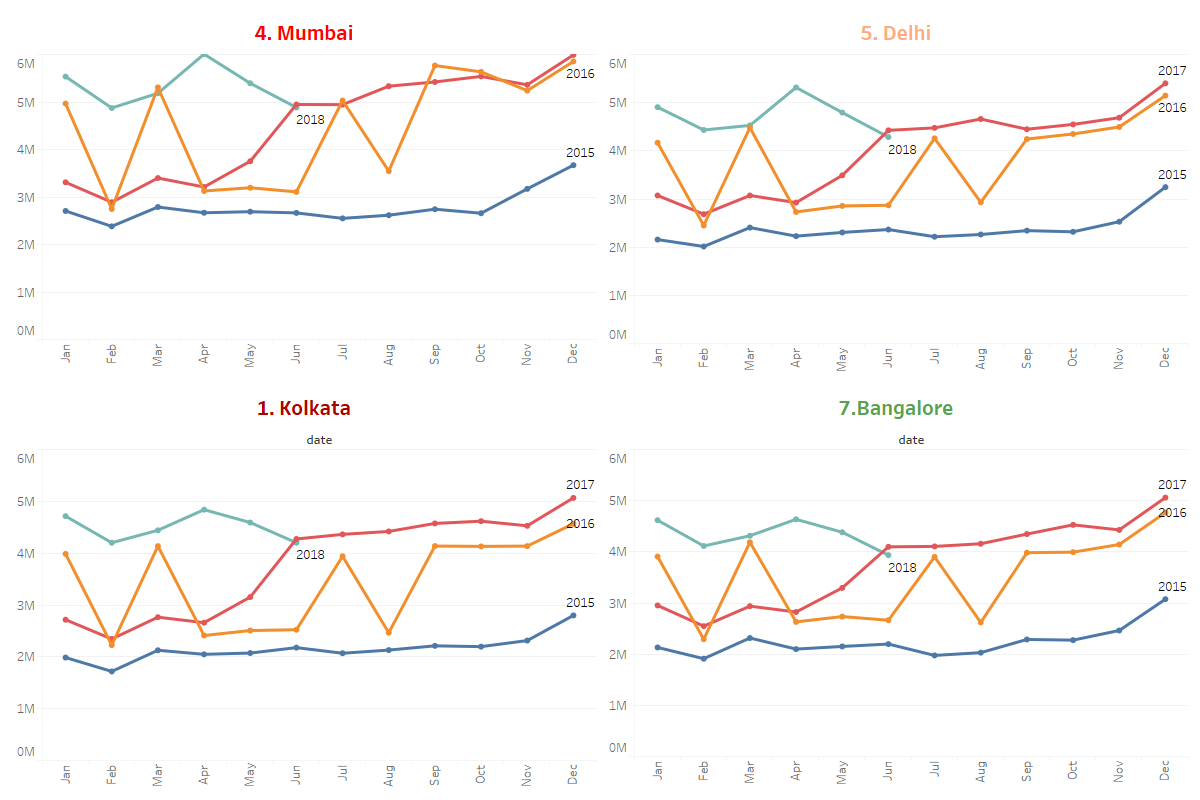

In [ ]:
# Read image
D_Top = Image.open('tableau_graphs/D_Top 4.png')
  
# Output Images
D_Top

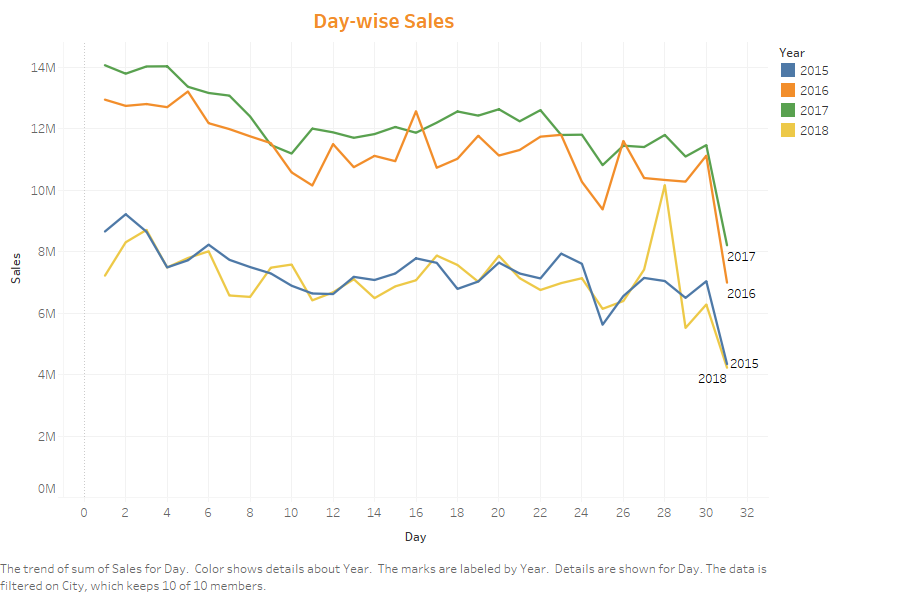

In [ ]:
# Read image
day_wise_Sales = Image.open('tableau_graphs/Day-wise Sales.png')
  
# Output Images
day_wise_Sales

### Observations:
* There is a downward trend that can be seen from the above plot.
* Sales are high in 1st week of the month and gradually decreases by the end of month.


* `28-Feb-2018` is the day when the most of the Medicines were sold in each city.
* We can see that `sales` and `foot_fall` is also the highest on the same day

Break-down of % of sales each month over the period of 4 years


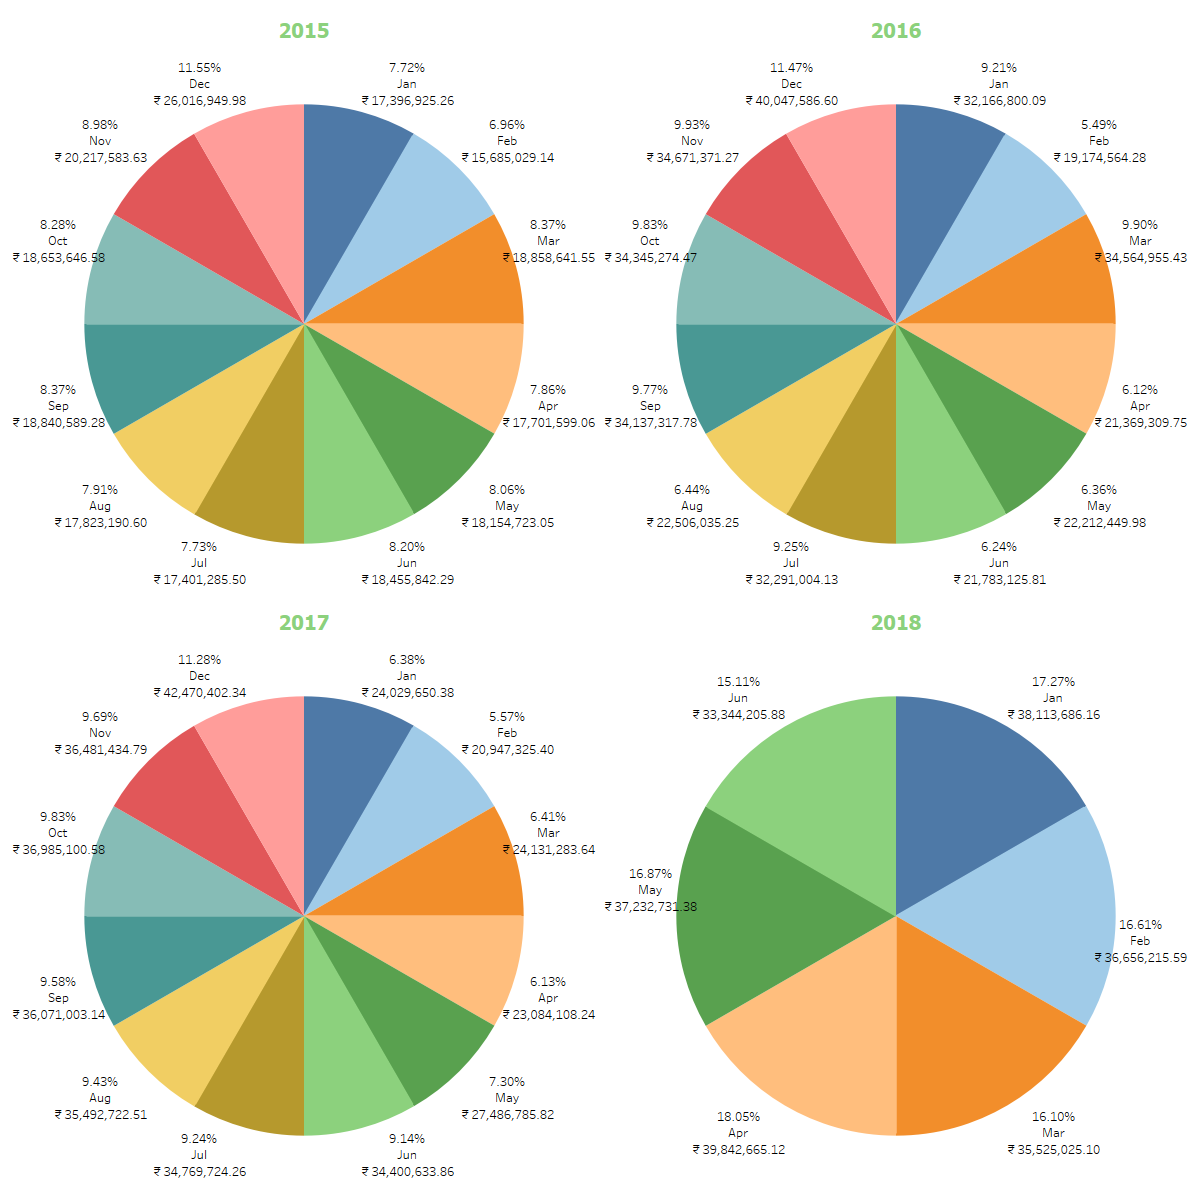

In [ ]:
print('Break-down of % of sales each month over the period of 4 years')

# Read image
Montly_sales_Pie = Image.open('tableau_graphs/Montly_sales_Pie.png')
  
# Output Images
Montly_sales_Pie

### Top 5 Medicines

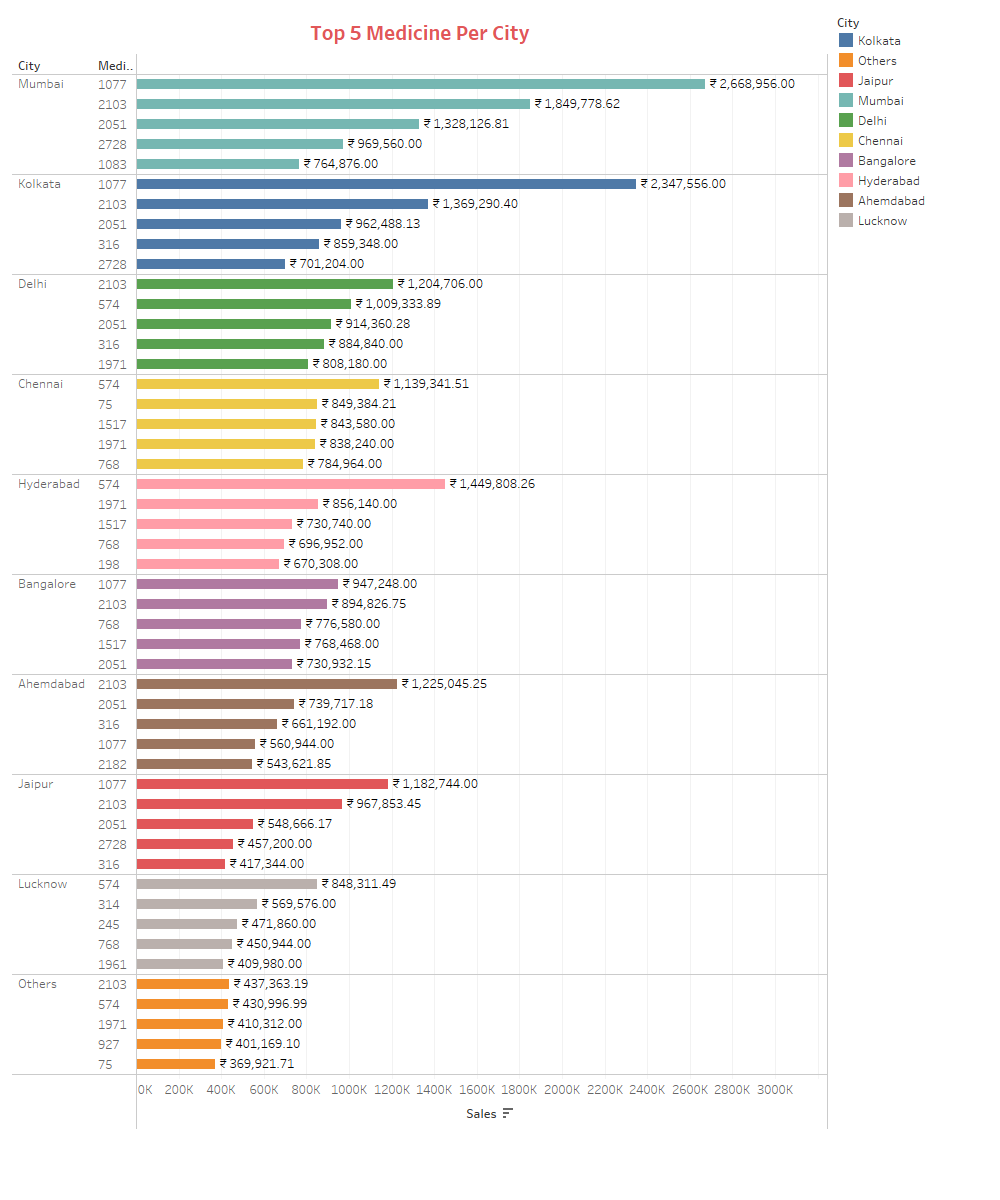

In [ ]:
# Read image
Top_5_Medicine_per_city = Image.open('tableau_graphs/Top_5_Medicine_per_city.png')
  
# Output Images
Top_5_Medicine_per_city

* Medicine Number `1077`, `2103`, `573`,`2050`,`315` are the ones which have sales more than `6 million` over the period of 2015 to 2018-june.
* Business needs to make sure that these medicines should always be availible in stock.
* In Mumbai  `1077`, `2103`, `2051`, `2728` and `1083` are the medicines that drive `more than 8 %` of sales. 
* In Kolkata `1077`,`2103`, `2051`,`316` and `2728` are the medicines that drive `more than 4.5%` of sales.

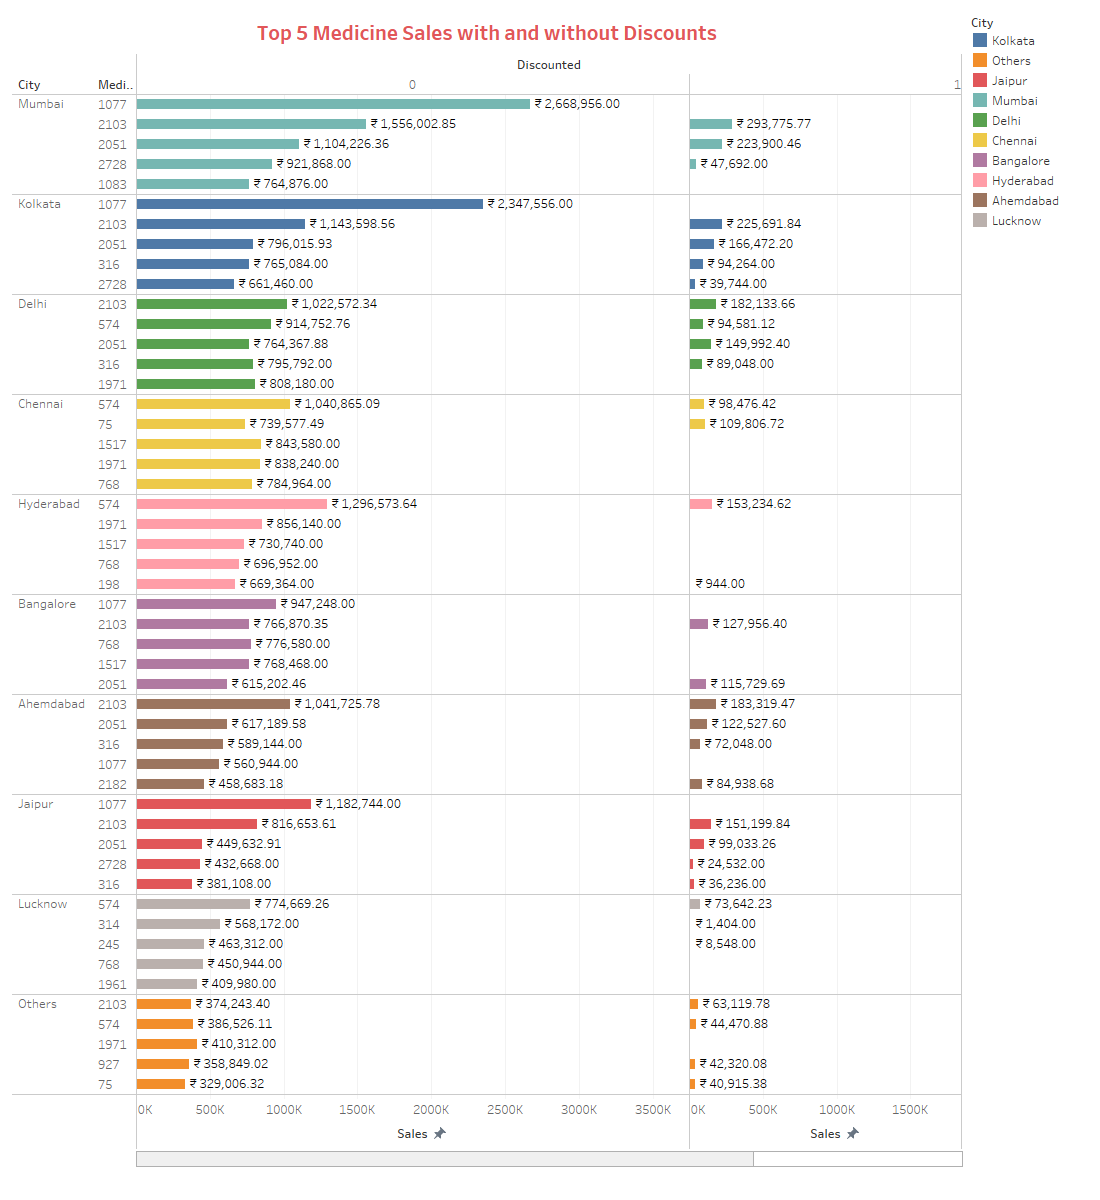

In [ ]:
# Read image
D_Top_5_sales_with_and_without_discount = Image.open('tableau_graphs/D_Top_5_sales_with_and_without_discount.png')
  
# Output Images
D_Top_5_sales_with_and_without_discount

#### Increase in sales due to discounts offered

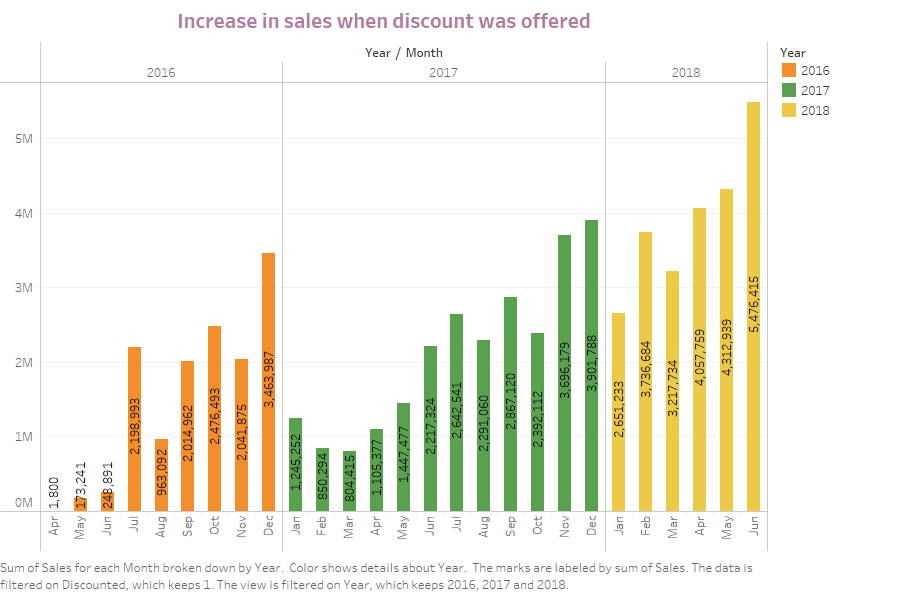

In [ ]:
# Read image
sale_increase = Image.open('tableau_graphs/sale_increase.png')
  
# Output Images
sale_increase

### Duplicate records to be dropped

In [ ]:
%%time
# check for duplicates

duplicate = merged_data[merged_data.duplicated()]
print('Duplicate records :',duplicate.shape)

# drop duplicate records
merged_data = merged_data.drop_duplicates()

Duplicate records : (45870, 8)
CPU times: user 12.5 s, sys: 1.32 s, total: 13.8 s
Wall time: 13.8 s


### Negative sales record analysis

In [ ]:
# There are some records with negative sales data entered

neg_sales = merged_data[merged_data['sales'] < 0]
print('Data size for columns with Negative sales entered :', neg_sales.shape)
print('Total sum of sales entered as Negative values :', neg_sales['sales'].sum())
neg_sales['discounted'].value_counts()

# neg_sales[neg_sales['sales'] < -1000].shape     #  (17,9)
# neg_sales[neg_sales['sales'] > -50].shape       #  (1451,9)

Data size for columns with Negative sales entered : (1672, 8)
Total sum of sales entered as Negative values : -112774.75


0    1672
Name: discounted, dtype: int64

In [ ]:
print('Total sales recorded negative in 2015 :',neg_sales[neg_sales['year'] == 2015]['sales'].sum())
print('Total sales recorded negative in 2016 :',neg_sales[neg_sales['year'] == 2016]['sales'].sum())
print('Total sales recorded negative in 2017 :',neg_sales[neg_sales['year'] == 2017]['sales'].sum())
print('Total sales recorded negative in 2018 :',neg_sales[neg_sales['year'] == 2018]['sales'].sum())

print('\n\nUpon Assuming that Negative sales is loss to business')
print('Negative sales sum in April 2018 :',neg_sales[(neg_sales['year'] == 2018) & (neg_sales['month'] == 4) ]['sales'].sum())

Total sales recorded negative in 2015 : -8775.8
Total sales recorded negative in 2016 : -16498.379
Total sales recorded negative in 2017 : -36740.195
Total sales recorded negative in 2018 : -50760.375


Upon Assuming that Negative sales is loss to business
Negative sales sum in April 2018 : -40404.83


### Medicine sales Observations

In [ ]:
%%time
med_sales = merged_data.groupby('medicine', as_index = False).agg({'sales': np.sum})
med_sales = med_sales.sort_values('sales' ,ascending = False)
med_sales.sort_values('sales' ,ascending = False).head()

CPU times: user 561 ms, sys: 14 ms, total: 575 ms
Wall time: 576 ms



* Medicine Number `1076`, `2103`, `573`,`2050`,`315` are the ones which have sales more than `5 million`

In [ ]:
print('Medicines with sales less than 10/- :',len(med_sales[med_sales['sales'] < 10]))
print('Medicines with sales less than 100/- :',len(med_sales[med_sales['sales'] < 100]))
print('Medicines with sales less than 1000/- :',len(med_sales[med_sales['sales'] < 1000]))
print('Medicines with sales less than 10000/- :',len(med_sales[med_sales['sales'] < 10000]))
print('Medicines with sales less than 100000/- :',len(med_sales[med_sales['sales'] < 100000]))
print('Medicines with sales less than MILLION/- :',len(med_sales[med_sales['sales'] < 1000000]))

Medicines with sales less than 10/- : 43
Medicines with sales less than 100/- : 72
Medicines with sales less than 1000/- : 121
Medicines with sales less than 10000/- : 313
Medicines with sales less than 100000/- : 1209
Medicines with sales less than MILLION/- : 3169


### Insights:

**From the given training data:**

* There are `43` products that have sales less than `10 INR`.

* There are `72` products that have sales less than `100 INR`.

* There are `121` products that have sales less than `1000 INR`.

* There are `313` products that have sales less than `10000 INR`.

**We can stop selling these products that fall in the above category or can make them availible for the customer on special orders.**

* There are `1209` products that have sales less than `100000 INR`.

In [ ]:
print('Medicines with sales greater than MILLION/- :', len(med_sales[med_sales['sales'] > 1000000]))
print('Medicines with sales greater than 2 MILLION/- :',len(med_sales[med_sales['sales'] > 2000000]))
print('Medicines with sales greater than 3 MILLION/- :',len(med_sales[med_sales['sales'] > 3000000]))
print('Medicines with sales greater than 4 MILLION/- :',len(med_sales[med_sales['sales'] > 4000000]))
print('Medicines with sales greater than 5 MILLION/- :',len(med_sales[med_sales['sales'] > 5000000]))
print('Medicines with sales greater than 6 MILLION/- :',len(med_sales[med_sales['sales'] > 6000000]))

Medicines with sales greater than MILLION/- : 220
Medicines with sales greater than 2 MILLION/- : 60
Medicines with sales greater than 3 MILLION/- : 27
Medicines with sales greater than 4 MILLION/- : 13
Medicines with sales greater than 5 MILLION/- : 8
Medicines with sales greater than 6 MILLION/- : 4


### Insights:

**From the given training data:**

* Medicine Number `1076`, `2103`, `573`,`2050`,`315` are the ones which have **SALES REVENUE** more than `5 million`

* There are `220` products that have sales greater than a `MILLION`.

* There are `60` products that have sales greater than `2 MILLION`.

* There are `27` products that have sales greater than `3 MILLION`.

* There are `13` products that have sales greater than `4 MILLION`.

* There are `8` products that have sales greater than `5 MILLION`.

In [ ]:
%%time
# save file for future use

merged_data.to_csv('model_data.csv')

CPU times: user 3min 37s, sys: 2.42 s, total: 3min 39s
Wall time: 3min 58s


#### Get the test data ready

In [ ]:
test_df = pd.merge(test_data, discounted, on= ['date','city','medicine'] , how = 'left')
test_df[['year','month','day']] = test_df[['year','month','day']].astype('int64')
print(test_df.head(2))
print('Merged_data shape :',test_df.shape) 
print('\nMemory Usage : ',mem_usage(test_df))

test_df = data_optimize(test_df)
print('\nMemory Usage after optimization : ',mem_usage(test_df))

        date  id  year  month  day  city  medicine  discounted
0 2018-07-01   1  2018      7    1     1      1292           0
1 2018-07-01   2  2018      7    1     1         1           0
Merged_data shape : (773535, 8)

Memory Usage :  35.41 MB

Memory Usage after optimization :  20.66 MB


In [ ]:
test_df.dtypes

date          datetime64[ns]
id                    uint32
year                  uint16
month                  uint8
day                    uint8
city                   uint8
medicine              uint16
discounted             uint8
dtype: object

In [ ]:
# Save id column for submission
id = test_data['id']
id.to_csv('test_id.csv')

In [ ]:
test_df = test_df.drop('id', axis =1)

In [ ]:
test_df.to_csv('test_df.csv')

In [ ]:
# delete variables that are not in use

del train_data, foot_fall, discounted

### Model Building 

In [7]:
%%time
# Call the dataset for regression modeling

df = pd.read_csv('model_data.csv', parse_dates=['date'])  # Train data
test_df = pd.read_csv('test_df.csv', parse_dates=['date'])
## Call the grouped data for analysis
# grp_data = pd.read_csv('grp_data.csv')  this is to plot time series for the sales on datewise
# grp_data = grp_data.drop('Unnamed: 0', axis = 1)

# drop unnecesary columns
df = df.drop(['Unnamed: 0', 'day'] , axis = 1)
test_df = test_df.drop(['Unnamed: 0','day'] , axis = 1)

df['day_of_week'] = df['date'].dt.dayofweek
test_df['day_of_week'] = test_df['date'].dt.dayofweek

df[['year', 'month', 'city','discounted','day_of_week']] = df[['year', 'month','city','discounted','day_of_week']].astype('category')
test_df[['year', 'month', 'city','discounted','day_of_week']] = test_df[['year', 'month', 'city','discounted','day_of_week']].astype('category')

df = data_optimize(df)  # optimize data
test_df = data_optimize(test_df)  # optimize data

print('Memory Usage for train_data (df ): ',mem_usage(df)) # memory used to load dataset
print('Memory Usage for test_data (test_df ): ',mem_usage(test_df)) # memory used to load dataset

Memory Usage for train_data (df ):  409.94 MB
Memory Usage for test_data (test_df ):  11.07 MB
CPU times: user 21.2 s, sys: 3.95 s, total: 25.1 s
Wall time: 31.5 s


In [8]:
# Encoding the medicine column by using Mean Encoding

medicine_en = df.groupby(['medicine'])['sales'].mean().to_dict()  
df['medicine'] =  df['medicine'].map(medicine_en) 
# df['medicine'] =  df['medicine'].astype('category')
test_df['medicine'] =  test_df['medicine'].map(medicine_en)
# test_df['medicine'] =  test_df['medicine'].astype('category')

In [9]:
del medicine_en
gc.collect()

50

In [10]:
train_df = df[(df['date'] >= '2018-01-02') & (df['date'] <= '2018-05-31')]  
val_df =  df[(df['date'] > '2018-05-31')]

# Now drop date column from train, val data
train_df.drop('date', axis = 1, inplace = True)
val_df.drop('date', axis = 1, inplace =True)

print('train_df :', train_df.shape)
print('val_df :', val_df.shape)

train_df : (3687180, 7)
val_df : (724184, 7)


In [11]:
# Lets seperate the features and labels from the train and test data

X_train = train_df.drop('sales', axis = 1)
y_train = train_df['sales']

X_test = val_df.drop('sales', axis = 1)
y_test = val_df['sales']

print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (3687180, 6)
y_train shape : (3687180,)
X_test shape : (724184, 6)
y_test shape : (724184,)


In [12]:
gc.collect()

50

In [13]:
X_train.dtypes

year           category
month          category
city           category
medicine        float64
discounted     category
day_of_week    category
dtype: object

In [14]:
# Encode the necessary features accordingly

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train_cat = pd.DataFrame(ohe.fit_transform(X_train[['year', 'month', 'day_of_week', 'city']]), columns = ohe.get_feature_names())

X_test_cat = pd.DataFrame(ohe.transform(X_test[['year', 'month', 'day_of_week', 'city']]), columns = ohe.get_feature_names())

In [15]:
gc.collect()
col = ['medicine','discounted']
print(X_train[col].reset_index(drop = True).shape)
print(X_test[col].reset_index(drop = True).shape)
print(X_train_cat.shape)
print(X_test_cat.shape)

(3687180, 2)
(724184, 2)
(3687180, 23)
(724184, 23)


In [16]:
X_test_cat.head()

,x0_2018,x1_1,x1_2,x1_3,x1_4,x1_5,x2_0,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x3_1,x3_2,x3_3,x3_4,x3_5,x3_6,x3_7,x3_8,x3_9,x3_10
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#Join the `medicine` and `disounted` columns to the encoded dataset

X_train = X_train_cat.join(X_train[col].reset_index(drop = True))
X_test = X_test_cat.join(X_test[col].reset_index(drop = True))

# clear the garbage files 
gc.collect()
del df, X_train_cat, X_test_cat

In [18]:
# Optimize data

X_train = data_optimize(X_train)
X_test = data_optimize(X_test)
gc.collect()

50

#### Random Forest Regressor

In [19]:
%%time
# import the regressor
from sklearn.model_selection import GridSearchCV 
param_grid = { 'n_estimators' : [17],
              'max_features' : [8]}
  
# create a regressor object
regressor = RandomForestRegressor() 

grid_search = GridSearchCV(regressor , param_grid, cv = 5)
  
# fit the regressor with X and Y data
grid_search.fit(X_train, y_train)

gc.collect()

# execution time is : 2 hrs 11 mins

CPU times: user 11min 9s, sys: 1.07 s, total: 11min 10s
Wall time: 11min 25s


In [20]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 17}

In [21]:
grid_search.cv_results_
# for mean_score,params in zip(cv_res['me'])

{'mean_fit_time': array([107.71284633]),
 'mean_score_time': array([3.85760679]),
 'mean_test_score': array([0.63041011]),
 'param_max_features': masked_array(data=[8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[17],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 8, 'n_estimators': 17}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.72951172]),
 'split1_test_score': array([0.7294676]),
 'split2_test_score': array([0.72751849]),
 'split3_test_score': array([0.24979852]),
 'split4_test_score': array([0.7157542]),
 'std_fit_time': array([7.82991055]),
 'std_score_time': array([0.06692645]),
 'std_test_score': array([0.19037455])}

In [22]:
%%time
# test the output on validation data
y_pred = grid_search.predict(X_test)

CPU times: user 4.19 s, sys: 27 ms, total: 4.22 s
Wall time: 4.2 s


In [23]:
%%time
y_t = y_test.copy().values
print(y_t)
y_pred

[ 4. 32. 32. ...  8.  4. 56.]
CPU times: user 3.18 ms, sys: 2 µs, total: 3.18 ms
Wall time: 2.37 ms


In [28]:
%%time
from sklearn.metrics import mean_squared_error, r2_score
print('RMSE train: ', mean_squared_error(y_train, grid_search.predict(X_train), squared=False) )
print('RMSE test: ', mean_squared_error(y_test, y_pred , squared=False) ) 
print('r2_score : ', r2_score(y_test, y_pred ))
# squaredbool, default=True
# If True returns MSE value, if False returns RMSE value.

RMSE train:  67.71641089064538
RMSE test:  53.21739675489145
r2_score :  0.7007250604824692
CPU times: user 19.9 s, sys: 25.8 ms, total: 19.9 s
Wall time: 19.8 s


#### Save the model

In [ ]:
# import pickle

# pickle.dump(regressor,file= open('model', 'wb'))

# # load the model from disk
# dt_model = pickle.load(open('model', 'rb'))

#### Run the model on the test data

In [ ]:
# Encode the test data 
test_df_cat = pd.DataFrame(ohe.transform(test_df[['year', 'month', 'day_of_week', 'city']]), columns = ohe.get_feature_names())
test_df_cat.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,x0_2018,x1_1,x1_2,x1_3,x1_4,x1_5,x2_0,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x3_1,x3_2,x3_3,x3_4,x3_5,x3_6,x3_7,x3_8,x3_9,x3_10
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
col = ['medicine','discounted']

test_df_dt = test_df_cat.join(test_df[col].reset_index(drop = True))

In [ ]:
test_df_dt = data_optimize(test_df_dt)   # optimize the data 

In [ ]:
gc.collect()

416

In [ ]:
test_df_dt.shape

(773535, 25)

In [ ]:
test_df_dt['medicine'].isna().sum()

2335

In [ ]:
# As there are missing values now lets fill the values with the median

test_df_dt['medicine'].fillna(train_df['medicine'].median(), inplace = True)

In [ ]:
gc.collect()

308

In [ ]:
# test the output on test data

test_output = grid_search.predict(test_df_dt)
test_output

array([18.88095238, 20.9627451 , 72.64325452, ..., 15.34117647,
       46.14640523, 39.84817927])

In [ ]:
# call the submission file
sample_sub = pd.read_csv('sample_submission.csv')

In [ ]:
sample_sub.shape

(773535, 2)

In [ ]:
sample_sub['sales'] = test_output
sample_sub

,id,sales
0,1,18.880952
1,2,20.962745
2,3,72.643255
3,4,49.992437
4,5,10.340056
...,...,...
773530,773531,36.983940
773531,773532,26.178431
773532,773533,15.341176
773533,773534,46.146405


In [ ]:
# Save the model submission
sample_sub.to_csv('rf_17-8_week.csv', index = False)

In [ ]:
%%shell
jupyter nbconvert --to html '/content/gdrive/MyDrive/Final_project/Vishal_B95_4038.ipynb'

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Final_project/vishal_B95_FH.ipynb to html
[NbConvertApp] Writing 3240409 bytes to /content/gdrive/MyDrive/Final_project/vishal_B95_FH.html


#### **Recommendations to Business**

* We can stop selling 303 products that has sales of less than 10,000 rupees in 3 years or an alternative can make them availible for the customer on special orders.
* Medicine Number `1076`, `2103`, `573`,`2050`,`315` are the ones which have *SALES REVENUE* more than `6 million`, over the period of 2015 to 2018-june so these medicines to be made availible in each store all time.
* As per data Mumbai, Delhi, Kolkata, Bangalore are the top 4 locations where the sales are the highest in the country.
* Business needs to make sure that these medicines should always be availible in stock.
* In Mumbai  `1077`, `2103`, `2051`, `2728` and `1083` are the medicines that drive `more than 8 %` of sales. So these should be always be in stock.
* In Kolkata `1077`,`2103`, `2051`,`316` and `2728` are the medicines that drive `more than 4.5%` of sales. So these should be always present in stock.

#### **Explain model in Non-Technical terms**

Here we are trying to forecast the sales for the month of september 2018. We are using the 2018 (Jan to June) data to make the algorithm learn and apply those learnings to make sales predictions on test data.

The model we ran here is called as Decision Tree and Random Forest. Decision tree is same as what we use to plot in childhood when we were learning the tree diagram. It Plots something similar to it.

Random Forest is the collection of decision Trees in laymen terms it is a Forest of random trees, where the final result is taken to be an average (regression) from among the individual trees.

Now each tree has different set of branches(columns) and different variety of fruits(rows) so we try to get the mode of there output from the selected set of trees i.e., which ever output has the majority that output is selected. Similarly we run this expriment with differnt sizes of forest and which ever forest has the best result we choose that forest for future use.



#### Save code file as HTML